<a href="https://colab.research.google.com/github/codebluecruz/Getting-started-with-github/blob/master/Labeled%20set%20on%20final%20webmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis w/ Python

This kernel comprise exploratory data analysis on the provided data, including: 
- Data loading
- Data cleaning 
- Descriptive Analysis
- Temporal Analysis
- Sentiment Analysis
- Text Analysis



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import re
import seaborn as sns
import string
import html
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import normalize, MinMaxScaler
from scipy.stats import spearmanr, pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from collections import Counter
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import warnings; warnings.simplefilter('ignore')
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all" # To see all the outputs in the notebook, not only the last one
#pd.set_option('display.max_colwidth', -1) # To see all text in reviews

plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Loading Data

Since we are just doing an exploratory analysis of the data, **we are going to concatenate test and train data into one dataset**.

In [3]:
# Reading data 
drugs = pd.read_csv('/content/drive/My Drive/WebMd_Final_withSR.csv', skiprows=0)
drugs

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Sentiment_Rating,Sex,Sides,UsefulCount,Satisfaction
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0,5
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1,5
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,5,Female,,0,3
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0,1
4,35-44,Other,01-06-2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99983,45-54,Sensation of Spinning or Whirling,07-02-2008,meclizine hcl,4520,5,3,I used this medicine for vertigo. It is somewh...,3,Male,"Drowsiness, dry mouth , and tiredness may occur.",4,2
99984,,Major Depressive Disorder,03-03-2011,mirtazapine tablet,13706,5,5,when I had to go off of it because my insuranc...,5,Female,"Dizziness , drowsiness, lightheadedness , inc...",1,5
99985,55-64,Other,04-07-2011,mirtazapine,13706,1,1,,5,,"Dizziness , drowsiness, lightheadedness , inc...",1,1
99986,19-24,Birth Control,1/25/2011,mirena intrauterine device,20420,1,4,I got the mirena in may of 08 after my son was...,1,Female,"Pain, bleeding, or dizziness during and afte...",4,1


In [4]:
drugs = drugs.dropna(how = 'any', axis = 0)
drugs.shape
drugs.columns = drugs.columns.str.lower()
drugs.reset_index(drop = True, inplace = True)
drugs['condition'].isnull().sum(axis = 0)

#dropping unnecessary columns
drugs.drop(['date'], axis=1, inplace=True)


In [5]:
drugs.head()

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,sentiment_rating,sex,sides,usefulcount,satisfaction
0,75 or over,Stuffy Nose,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0,5
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1,5
2,65-74,Other,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,5,Female,,0,3
3,75 or over,Other,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0,1
4,35-44,Other,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1,1


## Data Cleaning and Data Glimpse

We are willing to check if this dataset have some corrupted data or non present values. 

**condition** is a field which present problems in 1171 registers, probably due to some bug in the data web scraping. The value of those registers is the usefulCount value with an ```span``` HTML tag and the following text: ```users found this comment helpful```. We ignored these registers.

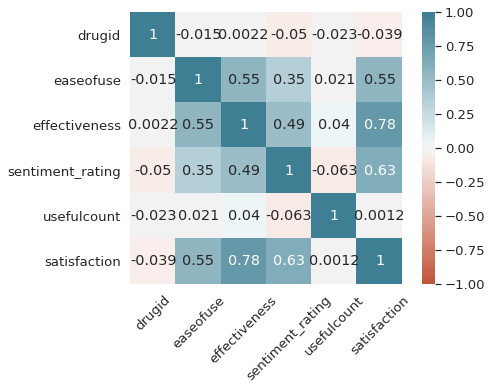

In [6]:
# Heatmap of the correlation matrix
plt.rcParams['figure.figsize'] = [7,5]
sns.set(font_scale = 1.2)
corr = drugs.select_dtypes(include = 'int64').corr()
sns_heat = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200), square=True);
plt.setp(sns_heat.get_xticklabels(), rotation = 45);

In [7]:
# Let's delete all of these corrupted rows
print("Number of Corrupted Reviews: ", len(drugs[drugs.condition.str.contains(" users found this comment helpful.",na=False)]))
drugs = drugs[~drugs.condition.str.contains(" users found this comment helpful.",na=False)]

Number of Corrupted Reviews:  0


In [8]:
drugs.describe() 

,drugid,easeofuse,effectiveness,sentiment_rating,usefulcount,satisfaction
count,99988.000000,99988.000000,99988.000000,99988.000000,99988.000000,99988.000000
mean,31735.897668,4.028193,3.513882,3.300116,6.689393,3.113674
std,48797.503040,1.303018,1.429267,1.777164,9.086882,1.592108
min,43.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,2798.000000,3.000000,3.000000,1.000000,1.000000,1.000000
50%,8486.000000,5.000000,4.000000,4.000000,4.000000,3.000000
75%,20663.000000,5.000000,5.000000,5.000000,9.000000,5.000000
max,178044.000000,5.000000,5.000000,5.000000,154.000000,5.000000


In [9]:
### Thought flow for Depression Confidence Intervals
"""
I want to take the df, filter by condition, drug, confidence interval, sample size cutoff)
Then loop through all the drugs for a specific condition and calculate their
mean, top limit, and bottom limit. 
"""
# Create Confidence Interval Function
def confidence_interval (data, ci_percent):
  data = np.array(data) # Makes sure our data is in a numpy array
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + ci_percent) / 2., n - 1)
  return (mean, mean - interval, mean + interval)


def condition_compare (drugs, condition_id, ci_percent, sample_size_cutoff):
  output_names = ["Drug Name", "Sample Mean", "Lower Bound", "Upper Bound", "Sample Size"]
  drug_compare = []
  data = drugs[drugs.condition == condition_id]
  for drug in data.drug.unique():
    one_drug = data[data.drug == drug].satisfaction
    if one_drug.size > sample_size_cutoff:
      mean, ilower, iupper= confidence_interval(one_drug, ci_percent)
      entry = [drug, mean, ilower, iupper, one_drug.size]
      drug_compare.append(entry)
  return pd.DataFrame(drug_compare, columns=output_names)


drugs2 = condition_compare(drugs, "Cough", 0.95, 10).sort_values(by="Sample Mean", ascending=False)
drugs2

,Drug Name,Sample Mean,Lower Bound,Upper Bound,Sample Size
1,mucinex,2.553922,2.333316,2.774528,204
0,mucinex dm,2.551440,2.350144,2.752737,243


In [10]:
drugs['uniqueid'] = np.arange(len(drugs))
drugs

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,sentiment_rating,sex,sides,usefulcount,satisfaction,uniqueid
0,75 or over,Stuffy Nose,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0,5,0
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1,5,1
2,65-74,Other,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,5,Female,,0,3,2
3,75 or over,Other,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0,1,3
4,35-44,Other,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99983,45-54,Sensation of Spinning or Whirling,meclizine hcl,4520,5,3,I used this medicine for vertigo. It is somewh...,3,Male,"Drowsiness, dry mouth , and tiredness may occur.",4,2,99983
99984,,Major Depressive Disorder,mirtazapine tablet,13706,5,5,when I had to go off of it because my insuranc...,5,Female,"Dizziness , drowsiness, lightheadedness , inc...",1,5,99984
99985,55-64,Other,mirtazapine,13706,1,1,,5,,"Dizziness , drowsiness, lightheadedness , inc...",1,1,99985
99986,19-24,Birth Control,mirena intrauterine device,20420,1,4,I got the mirena in may of 08 after my son was...,1,Female,"Pain, bleeding, or dizziness during and afte...",4,1,99986


In [11]:
# We will use this groupings later on...

print("Number of Reviews per Drug")
# Number of reviews per drug
reviews_per_drug = drugs.groupby(["drug"]).agg({
    "uniqueid": pd.Series.nunique
})
reviews_per_drug.describe()


print("Number of Reviews per Condition")
# Number of reviews per condition
reviews_per_condition = drugs.groupby(["condition"]).agg({
    "uniqueid": pd.Series.nunique
})

reviews_per_condition.describe()

Number of Reviews per Drug
Number of Reviews per Condition


,uniqueid
count,846.000000
mean,118.189125
std,780.561030
min,1.000000
25%,2.000000
50%,7.000000
75%,35.000000
max,12973.000000


#### Some RegEx to clean this text up. 

In [12]:
# Clean up text with RegEx
pd.set_option('display.width', 1000)
rx_pat = r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)"
rx_pat_wSpace = r"(\-)|(\\)|(\s{2,})"
    
drugs['reviews'].replace(regex=True,inplace=True,to_replace=rx_pat, value=r'')
drugs['reviews'].replace(regex=True,inplace=True,to_replace=rx_pat_wSpace, value=r' ')
drugs.reviews.head(5)

0    Im a retired physician and of all the meds I h...
1    cleared me right up even with my throat hurtin...
2        why did my PTINR go from a normal of to over 
3                          FALLING AND DONT REALISE IT
4    My grandfather was prescribed this medication ...
Name: reviews, dtype: object

In [13]:
#club ratings into sentiment_rate
drugs['sentiment_rate'] = drugs["satisfaction"].apply(lambda x: 2 if x > 3 else (1 if ((x>1)&(x<=3)) else 0))
solution = drugs['sentiment_rate']
# Inspect the cleaned text. 
drugs['reviews'] = drugs['reviews'].str.lower()
drugs.head(5)


,age,condition,drug,drugid,easeofuse,effectiveness,reviews,sentiment_rating,sex,sides,usefulcount,satisfaction,uniqueid,sentiment_rate
0,75 or over,Stuffy Nose,25dph-7.5peh,146724,5,5,im a retired physician and of all the meds i h...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0,5,0,2
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1,5,1,2
2,65-74,Other,warfarin (bulk) 100 % powder,144731,2,3,why did my ptinr go from a normal of to over,5,Female,,0,3,2,1
3,75 or over,Other,warfarin (bulk) 100 % powder,144731,2,2,falling and dont realise it,1,Female,,0,1,3,0
4,35-44,Other,warfarin (bulk) 100 % powder,144731,1,1,my grandfather was prescribed this medication ...,1,Male,,1,1,4,0


## Descriptive Analysis


### Top 10 Reviewed Drugs

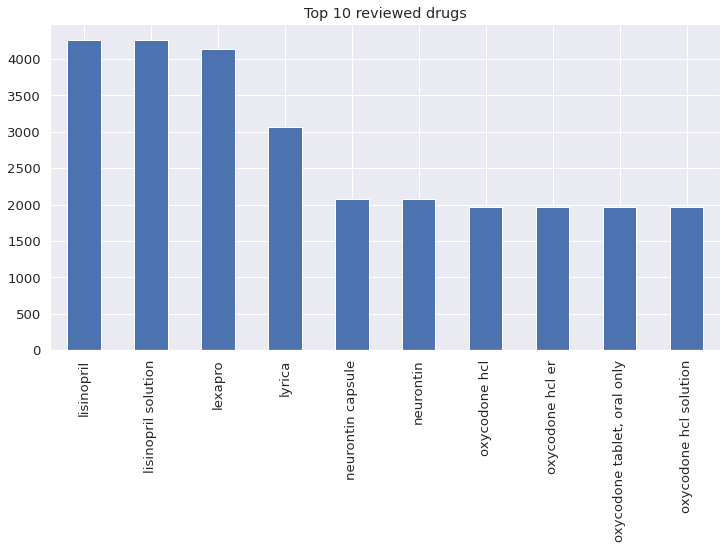

In [14]:
# Top 10 most reviewed drug names
plot = drugs.drug.value_counts().nlargest(10).plot(kind='bar', title="Top 10 reviewed drugs", figsize=(12,6))

### Top 10 conditions undergoing by drug reviewers

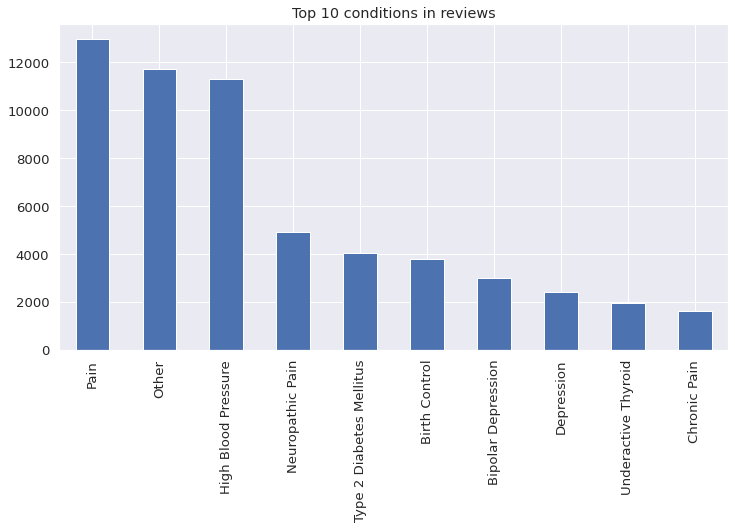

In [15]:
# Top 10 most suffered condition by reviewers
plot = drugs.condition.value_counts().nlargest(10).plot(kind='bar', title="Top 10 conditions in reviews", figsize=(12,6))

### Top 10 drugs with best and worst rating

When doing this analysis for all the drugs, there is a factor which affect the results: **the number of reviews of a drug**. I.e. if we want to compute the drug with best rating, the drug which in **only 1 review** was given a 10 rating would be in TOP 1. For this reason, we only consider drugs with a significant number of reviews. A significant number of reviews is when the number of reviews for a drug is above the 75% of the number of reviews distribution per drug.


Significant number of reviews: More than 23.0 reviews


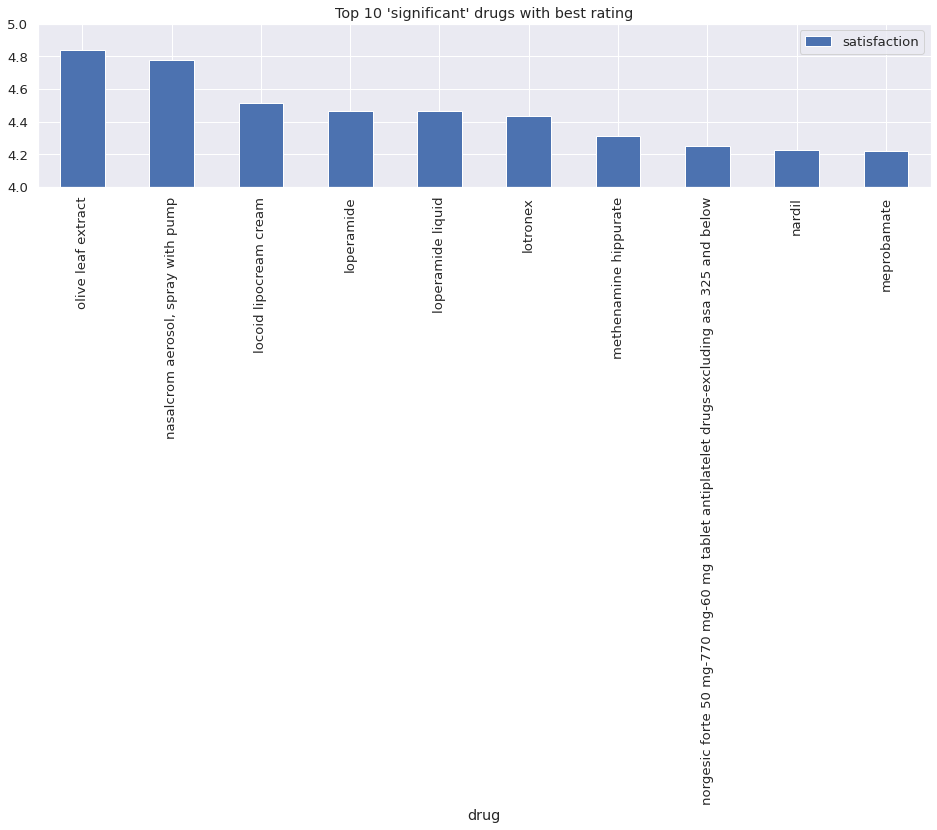

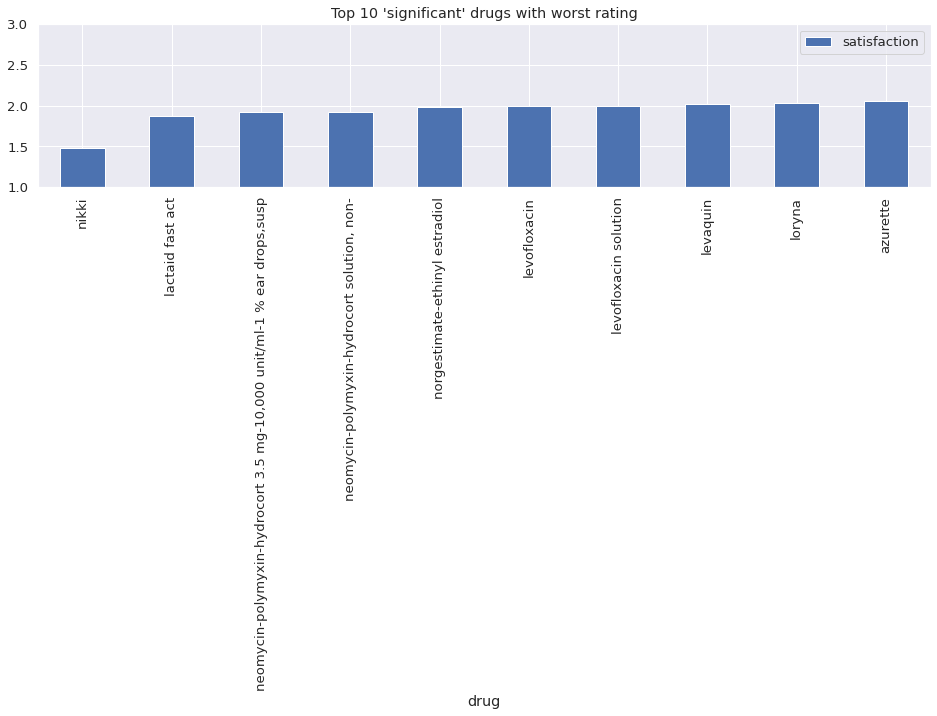

In [16]:
drugs_rating = drugs.groupby('drug').agg({
    'satisfaction': np.mean,
    'uniqueid': pd.Series.nunique
})

print("Significant number of reviews: More than", reviews_per_drug.quantile(q=0.75).values[0], "reviews")

# We only use the drugs which number of reviews is higher than a threshold
drugs_rating = drugs_rating[drugs_rating['uniqueid'] > int(reviews_per_drug.quantile(q=0.75))]

# Top 10
top_drugs_rating = drugs_rating.nlargest(10, 'satisfaction')
plot = top_drugs_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with best rating") # Assigned to variable to prevent output
dummy = plt.ylim(4, 5) # Assigned to variable to prevent output

# Bottom 10
bottom_drugs_rating = drugs_rating.nsmallest(10, 'satisfaction')
plot = bottom_drugs_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with worst rating") # Assigned to variable to prevent output
dummy = plt.ylim(1, 3) # Assigned to variable to prevent output

### Analyzing Pairs (Drug, Condition) with best and worst ratings

We theorize that the rating of a drug, is strongly related to the condition that the person who reviewed was suffering. We are going to compute the top 10 best and worst rating of reviews for (Drug, condition) pairs.

Number of pairs (Drug, Condition): 4286
Significant number of reviews: More than 10.0 reviews


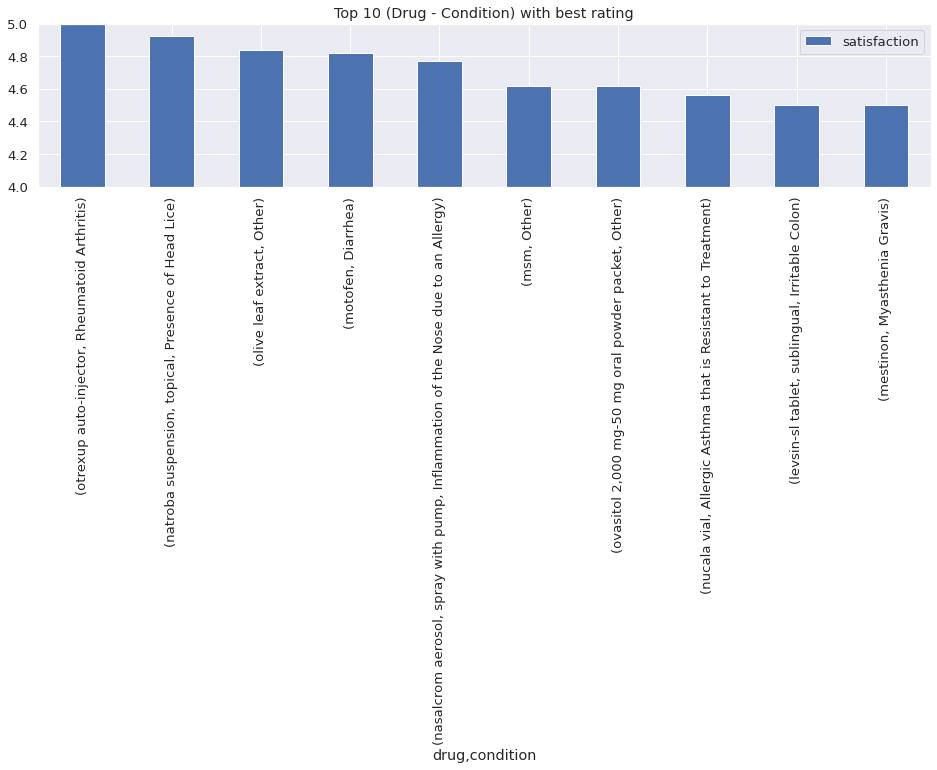

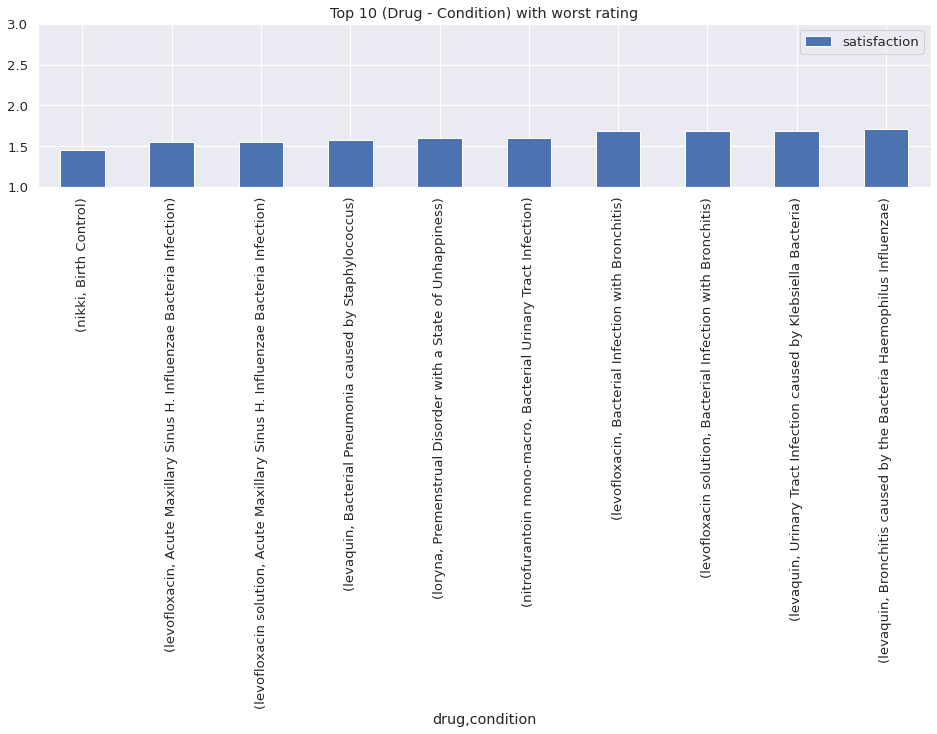

In [17]:
drugs_condition_rating = drugs.groupby(['drug', 'condition']).agg({
    'satisfaction': np.mean,
    'uniqueid': pd.Series.nunique
})

print("Number of pairs (Drug, Condition):", len(drugs_condition_rating))

print("Significant number of reviews: More than", drugs_condition_rating['uniqueid'].quantile(q=0.75), "reviews")

drugs_condition_rating = drugs_condition_rating[drugs_condition_rating['uniqueid'] > int(drugs_condition_rating['uniqueid'].quantile(q=0.75))]
# drugs_condition_rating.sort_values('rating', ascending=False)
top_drugs_condition_rating = drugs_condition_rating.nlargest(10, 'satisfaction')
plot = top_drugs_condition_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with best rating") # Assigned to variable to prevent output
dummy = plt.ylim(4, 5) # Assigned to variable to prevent output

bottom_drugs_condition_rating = drugs_condition_rating.nsmallest(10, 'satisfaction')
plot = bottom_drugs_condition_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with worst rating") # Assigned to variable to prevent output
dummy = plt.ylim(1, 3) # Assigned to variable to prevent output

## Temporal Analysis

Building a good prediction model is **no** trivial task. Temporal features ***could*** help a model to perform better if we can foresee some **temporal patterns**. We will analyze monthly patterns over different years of all the reviews.

In [18]:
def review_clean(reviews): 
    # changing to lower case
    lower = reviews.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [19]:
#df_data['review_clean'] = df_data['review'].apply(review_clean)
drugs['review_clean'] = review_clean(drugs['reviews'])

In [20]:
# Removing the stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
drugs['review_clean'] = drugs['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
# Removing the word stems using the Snowball Stemmer
Snow_ball = SnowballStemmer("english")
drugs['review_clean'] = drugs['review_clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))

## Sentiment Analysis

We will analyze the sentiment of the reviews. We theorize that **the sentiment embedded on a review can be a key factor** to determine the review rating, the review impact on people (usefulCount), or how good a drug is for an specific condition. 

However, reviews can expose many different manifestations, such as: condition symptoms (usually negative), feelings before the drug (usually negative), feelings after the drug (could be positive or negative), side effects (usually negative), symptoms after the drug (could be positive or negative). This mix of manifestations could make any sentiment analysis method to struggle determining a single score for the entire review. Therefore, a aspect-based S.A. could be more viable (such as the ones used by Gräßer et al.).

For now, we are going to use Vader [1], a rule-based sentiment analysis approach available in Python NLTK. To **obtain a single sentiment score for every review** (-1|negative to 1|positive), and see how it correlates with ratings (spearman coeff.).

Before doing this, **text** must be processed:

- HTML characters are converted to legible text
- Punctuation signs are removed

[1] Gilbert, C. H. E. (2014). Vader: A parsimonious rule-based model for sentiment analysis of social media text. In Eighth International Conference on Weblogs and Social Media (ICWSM-14). Available at (20/04/16) http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf.

In [22]:
def sentiment(reviews):
    # Sentiment polarity of the reviews
    pol = []
    for i in reviews:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol
drugs['sentiment'] = sentiment(drugs['reviews'])

drugs['sentiment_clean'] = sentiment(drugs['review_clean'])


In [23]:
np.corrcoef(drugs['sentiment'], drugs['satisfaction'])


array([[1.       , 0.2817206],
       [0.2817206, 1.       ]])

In [24]:
np.corrcoef(drugs['sentiment_clean'], drugs['satisfaction'])


array([[1.        , 0.19406179],
       [0.19406179, 1.        ]])

### VADER

In [25]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [26]:
%time   #to calulate the time it takes the algorithm to compute a VADER score

i=0 #counter

compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(drugs)):

    k = analyser.polarity_scores(drugs.iloc[i]['reviews'])
    compval1.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage

compval1 = np.array(compval1)

len(compval1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


99988

In [27]:
drugs['VADER score'] = compval1
np.corrcoef(drugs['VADER score'], drugs['satisfaction'])

array([[1.        , 0.30616743],
       [0.30616743, 1.        ]])

The Correlation coefficient between the sentiment of the uncleaned review with rating is greater than the cleaned review, so now lets try without the snowball stemmer and without removing the stopwords.

In [28]:
# Cleaning the reviews without removing the stop words and using snowball stemmer
drugs['review_clean_ss'] = review_clean(drugs['reviews'])
drugs['sentiment_clean_ss'] = sentiment(drugs['review_clean_ss'])


In [29]:
np.corrcoef(drugs['sentiment_clean_ss'], drugs['satisfaction'])


array([[1.        , 0.28177958],
       [0.28177958, 1.        ]])

In [30]:
drugs['condition'].value_counts().head(20)

Pain                                                         12973
Other                                                        11719
High Blood Pressure                                          11317
Neuropathic Pain                                              4901
Type 2 Diabetes Mellitus                                      4062
Birth Control                                                 3793
Bipolar Depression                                            3015
Depression                                                    2394
Underactive Thyroid                                           1938
Chronic Pain                                                  1613
Attention Deficit Disorder with Hyperactivity                 1233
Pain Originating From a Nerve                                 1012
Disorder characterized by Stiff, Tender & Painful Muscles      998
Joint Damage causing Pain and Loss of Function                 932
Repeated Episodes of Anxiety                                  

In [31]:
drugs.isna().sum()

age                   0
condition             0
drug                  0
drugid                0
easeofuse             0
effectiveness         0
reviews               0
sentiment_rating      0
sex                   0
sides                 0
usefulcount           0
satisfaction          0
uniqueid              0
sentiment_rate        0
review_clean          0
sentiment             0
sentiment_clean       0
VADER score           0
review_clean_ss       0
sentiment_clean_ss    0
dtype: int64

# Feature Engineering

In [32]:
#Word count in each review
drugs['count_word']=drugs["review_clean_ss"].apply(lambda x: len(str(x).split()))

#Unique word count 
drugs['count_unique_word']=drugs["review_clean_ss"].apply(lambda x: len(set(str(x).split())))

#Letter count
drugs['count_letters']=drugs["review_clean_ss"].apply(lambda x: len(str(x)))

#punctuation count
drugs["count_punctuations"] = drugs["reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


#Number of stopwords
drugs["count_stopwords"] = drugs["reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

#Average length of the words
drugs["mean_word_len"] = drugs["review_clean_ss"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [66]:
# Label Encoding Drugname and Conditions
from sklearn.preprocessing import LabelEncoder
label_encoder_feat = {}
for feature in ['drug', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    drugs[feature] = label_encoder_feat[feature].fit_transform(drugs[feature])

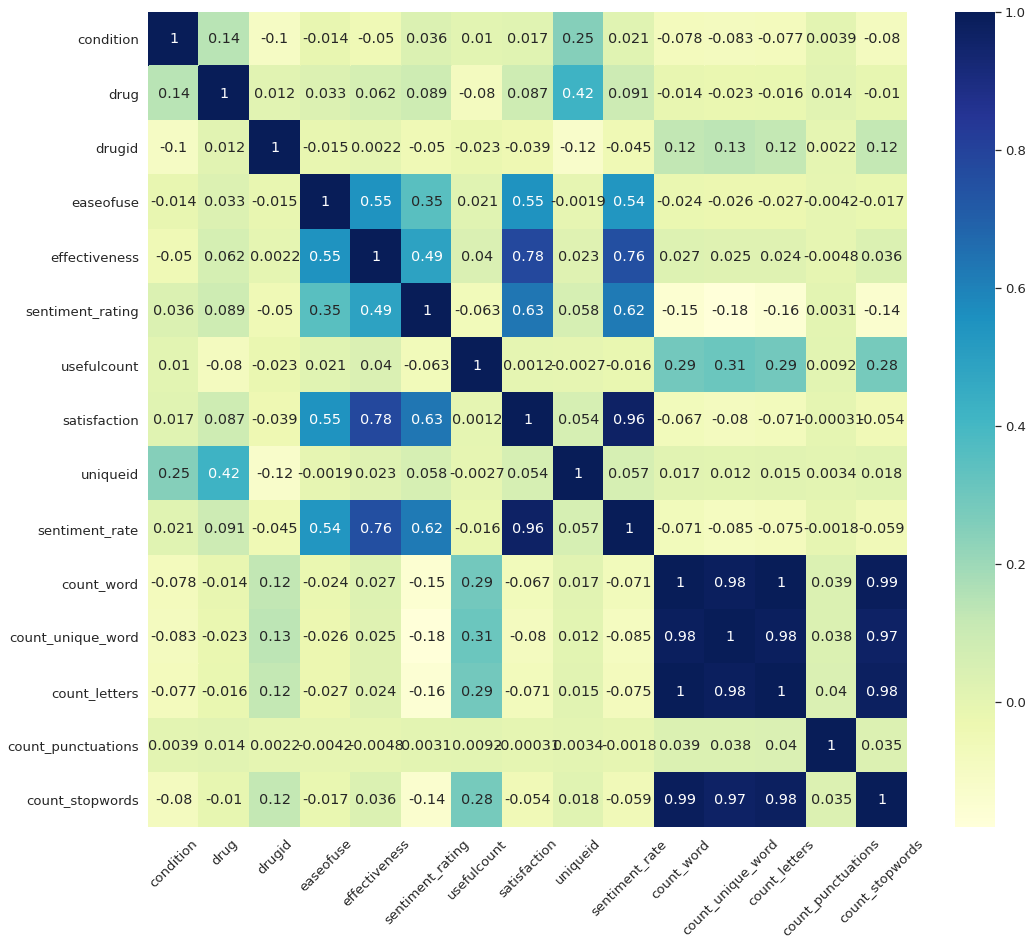

In [67]:
# Correlation Heatmap of the features engineered
plt.rcParams['figure.figsize'] = [17,15]
sns.set(font_scale = 1.2)
corr = drugs.select_dtypes(include = 'int64').corr()
sns_ = sns.heatmap(corr, annot = True, cmap = 'YlGnBu')
plt.setp(sns_.get_xticklabels(), rotation = 45);

In [99]:
drugs.head()

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,sentiment_rating,sex,sides,usefulcount,satisfaction,uniqueid,sentiment_rate,review_clean,sentiment,sentiment_clean,VADER score,review_clean_ss,sentiment_clean_ss,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len
0,75 or over,753,4,146724,5,5,im a retired physician and of all the meds i h...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0,5,0,2,im retir physician med tri allergi season one ...,0.337500,-0.050000,0.0891,im a retired physician and of all the meds i h...,0.337500,44,36,221,0,26,4.045455
1,25-34,195,4,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1,5,1,2,clear right even throat hurt went away take me...,0.285714,0.192857,-0.3182,cleared me right up even with my throat hurtin...,0.285714,16,16,86,0,7,4.437500
2,65-74,551,1335,144731,2,3,why did my ptinr go from a normal of to over,5,Female,,0,3,2,1,ptinr go normal,0.150000,0.150000,0.0000,why did my ptinr go from a normal of to over,0.150000,11,11,44,0,8,3.090909
3,75 or over,551,1335,144731,2,2,falling and dont realise it,1,Female,,0,1,3,0,fall dont realis,0.000000,0.000000,-0.1531,falling and dont realise it,0.000000,5,5,27,0,2,4.600000
4,35-44,551,1335,144731,1,1,my grandfather was prescribed this medication ...,1,Male,,1,1,4,0,grandfath prescrib medic coumadin assist blood...,0.046429,-0.181250,-0.3818,my grandfather was prescribed this medication ...,0.046429,72,56,415,0,34,4.777778


# Importing Libraries for the Machine Learning Model


In [68]:

from sklearn.model_selection import KFold, cross_val_score
#from lightgbm.sklearn import LGBMRegressor
#from sklearn.metrics import mean_squared_error


# Importing Libraries for the Machine Learning Model
from xgboost import XGBClassifier
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
import time
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_predict

In [135]:
# Defining Features and splitting the data as train and test set

features = drugs[['condition', 'usefulcount', 'sentiment', 'easeofuse', 'effectiveness',
                   'count_word', 'count_unique_word', 'count_letters',
                   'count_stopwords']]

target = drugs['sentiment_rate']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, shuffle=True, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (69991, 9)
The Test set size  (29997, 9)


In [136]:

knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 61.77
Time consumed for training: 0.174 seconds
Time consumed for prediction: 1.19590 seconds


In [137]:
LGBM = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )

training_start = time.perf_counter()
LGBM.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = LGBM.predict(X_test)
prediction_end = time.perf_counter()
acc_LGBM = (preds == y_test).sum().astype(float) / len(preds)*100
LGBM_train_time = training_end-training_start
LGBM_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's LR Classifier's prediction accuracy is: %3.2f" % (acc_LGBM))
print("Time consumed for training: %4.3f seconds" % (LGBM_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LGBM_prediction_time))


Scikit-Learn's LR Classifier's prediction accuracy is: 84.67
Time consumed for training: 120.233 seconds
Time consumed for prediction: 21.06640 seconds


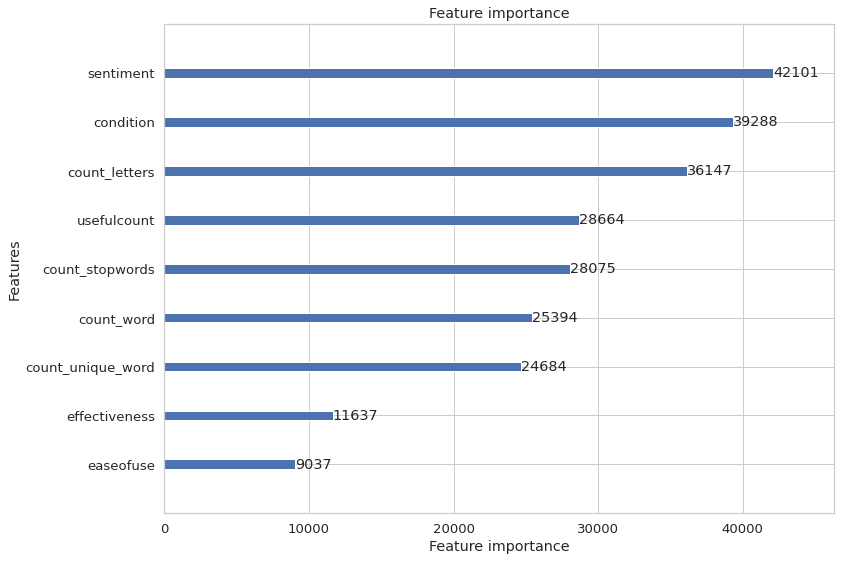

In [138]:
# Feature Importance Plot using LGBM
plt.rcParams['figure.figsize'] = [12, 9]
sns.set(style = 'whitegrid', font_scale = 1.2)
plot_importance(LGBM);

In [134]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)

training_start = time.perf_counter()
gbk.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gbk.predict(X_test)
prediction_end = time.perf_counter()
acc_gbk = (preds == y_test).sum().astype(float) / len(preds)*100
gbk_train_time = training_end-training_start
gbk_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's GBK Classifier's prediction accuracy is: %3.2f" % (acc_gbk))
print("Time consumed for training: %4.3f seconds" % (gbk_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gbk_prediction_time))

Scikit-Learn's GBK Classifier's prediction accuracy is: 64.73
Time consumed for training: 33.166 seconds
Time consumed for prediction: 0.15665 seconds


In [105]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 78.79
Time consumed for training: 8.696
Time consumed for prediction: 0.28224 seconds


In [106]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
training_start = time.perf_counter()
LR.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = LR.predict(X_test)
prediction_end = time.perf_counter()
acc_LR = (preds == y_test).sum().astype(float) / len(preds)*100
LR_train_time = training_end-training_start
LR_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's LR Classifier's prediction accuracy is: %3.2f" % (acc_LR))
print("Time consumed for training: %4.3f seconds" % (LR_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LR_prediction_time))


Scikit-Learn's LR Classifier's prediction accuracy is: 64.10
Time consumed for training: 3.836 seconds
Time consumed for prediction: 0.00429 seconds


In [107]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier()
training_start = time.perf_counter()
MLP.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = MLP.predict(X_test)
prediction_end = time.perf_counter()
acc_MLP = (preds == y_test).sum().astype(float) / len(preds)*100
MLP_train_time = training_end-training_start
MLP_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's LR Classifier's prediction accuracy is: %3.2f" % (acc_MLP))
print("Time consumed for training: %4.3f seconds" % (MLP_train_time))
print("Time consumed for prediction: %6.5f seconds" % (MLP_prediction_time))


Scikit-Learn's LR Classifier's prediction accuracy is: 73.64
Time consumed for training: 11.110 seconds
Time consumed for prediction: 0.04489 seconds


In [108]:
from sklearn.ensemble import RandomForestClassifier
import time

rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 84.89
Time consumed for training: 1.303 seconds
Time consumed for prediction: 0.09642 seconds


In [109]:
#After running all classifier models individually, we compare them all together for best performance
results = pd.DataFrame({
    'Model': ['KNN', 'LGBM', 'gbk', 'XGBoost', 'LR', 'MLP', 'Random Forest'],
    'Score': [acc_knn, acc_LGBM, acc_gbk, acc_xgb, acc_LR, acc_MLP, acc_rfc],
    'Runtime Training': [knn_train_time, LGBM_train_time, gbk_train_time, 
                         xgb_train_time, LR_train_time, MLP_train_time, rfc_train_time],
    'Runtime Prediction': [knn_prediction_time, LGBM_prediction_time, gbk_prediction_time,
                          xgb_prediction_time, LR_prediction_time, MLP_prediction_time, rfc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
Random Forest,84.891823,1.303438,0.096417
LGBM,84.668467,120.510240,20.973868
gbk,78.954562,34.103578,0.179776
XGBoost,78.794546,8.695935,0.282235
MLP,73.637364,11.110427,0.044892
LR,64.096410,3.836217,0.004291
KNN,61.772844,0.172455,1.170504


In [110]:
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.85857143 0.86255179 0.85683669 0.86426632 0.8656951  0.85826547
 0.85969424 0.86626661 0.86169453 0.86183741]
Mean: 0.8615679586879759
Standard Deviation: 0.003053353739462165


In [111]:
importances = pd.DataFrame({
    #'Feature': dTreated.drop('Satisfaction', axis=1).columns,
    'Feature': features.columns,
    'Importance': rfc.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=True)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
count_stopwords,0.057817
count_word,0.060029
count_unique_word,0.060656
usefulcount,0.061646
count_letters,0.087196
condition,0.088137
easeofuse,0.092399
sentiment,0.093413
effectiveness,0.398707


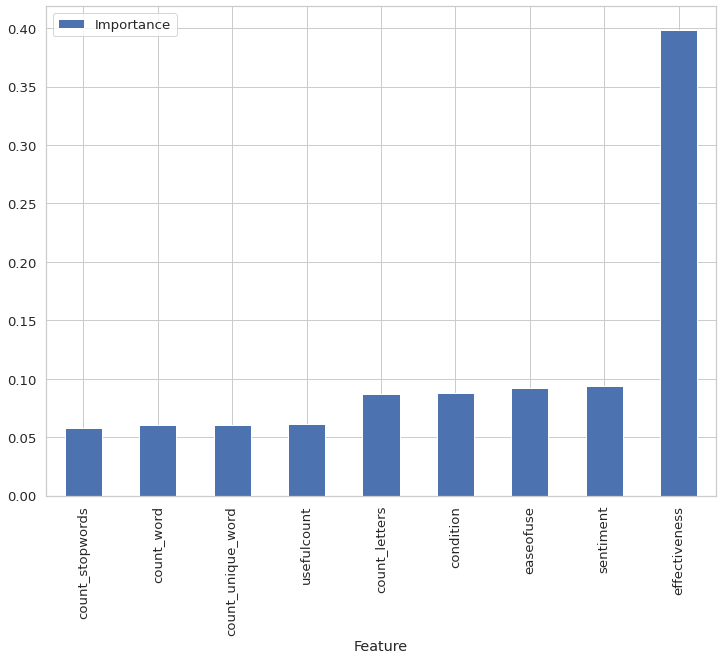

In [112]:
importances.plot.bar()

# Hyperparameter Tuning

In [113]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [114]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 24, 38, 52, 67, 81, 95, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 650, 1100, 1550, 2000]}


In [115]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)

In [116]:
# Best parameter values, with best score of accuracy using Hyperparameter tuning
#rf_random.best_params_,rf_random.best_score_

In [117]:
#implementing hyperopt tuning with set parameter values
RForest = RandomForestClassifier(bootstrap=True, max_depth=24, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200)

RForest.fit(X_train, y_train)
preds = RForest.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("RandomForest's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

RandomForest's prediction accuracy WITH optimal hyperparameters is: 86.07


In [118]:
scores1 = cross_val_score(RForest, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores1)
print("Mean:", scores1.mean())
print("Standard Deviation:", scores1.std())

Scores: [0.85928571 0.86255179 0.85912273 0.86483783 0.86155165 0.85726532
 0.85983712 0.86469496 0.86469496 0.86155165]
Mean: 0.861539372971649
Standard Deviation: 0.0025279408859441815


In [119]:
# class 0 represents 1, 1 is 2, 2 is 3, 3 is 4, 4 is 5 in actual dataset for column Satisfaction(output)


In [120]:
predictions = cross_val_predict(RForest, features, target, cv=3)
confusion_matrix(target, predictions)

array([[19993,  4829,  2672],
       [ 3991, 14284,  6996],
       [  666,  3415, 43142]])

In [121]:
print("Precision:", precision_score(target, predictions, average='micro'))
print("Recall:",recall_score(target, predictions, average='micro'))

Precision: 0.774282913949674
Recall: 0.774282913949674


In [122]:
print("F1-Score:", f1_score(target, predictions, average='micro'))

F1-Score: 0.774282913949674


In [123]:
# Classification report
import sklearn.metrics as metrics
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(target, predictions))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.81      0.73      0.77     27494
           1       0.63      0.57      0.60     25271
           2       0.82      0.91      0.86     47223

    accuracy                           0.77     99988
   macro avg       0.75      0.74      0.74     99988
weighted avg       0.77      0.77      0.77     99988



In [124]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_test)
y_test1 = lb.transform(y_test)
y_pred1= lb.transform(preds)
roc_auc_score(y_test1, y_pred1, average="macro")

0.8814395823264926

In [126]:

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp



statis=target
y = label_binarize(statis, classes=[0, 1, 2])
n_classes = y.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

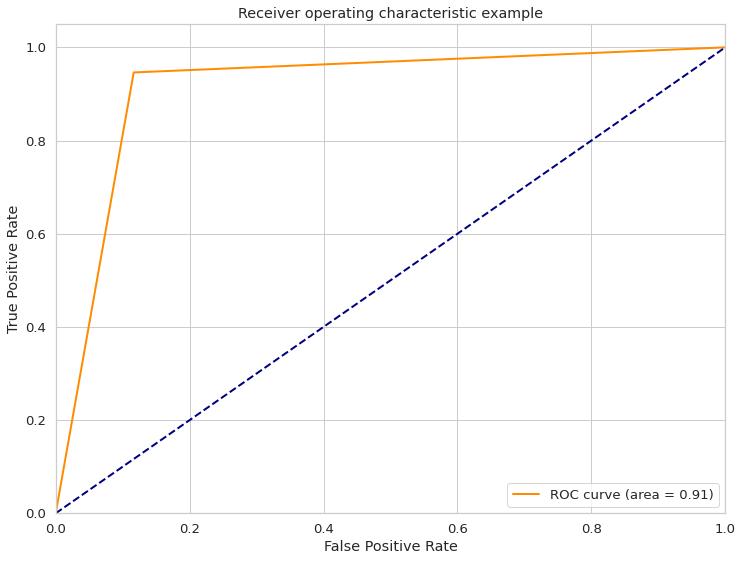

In [128]:

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

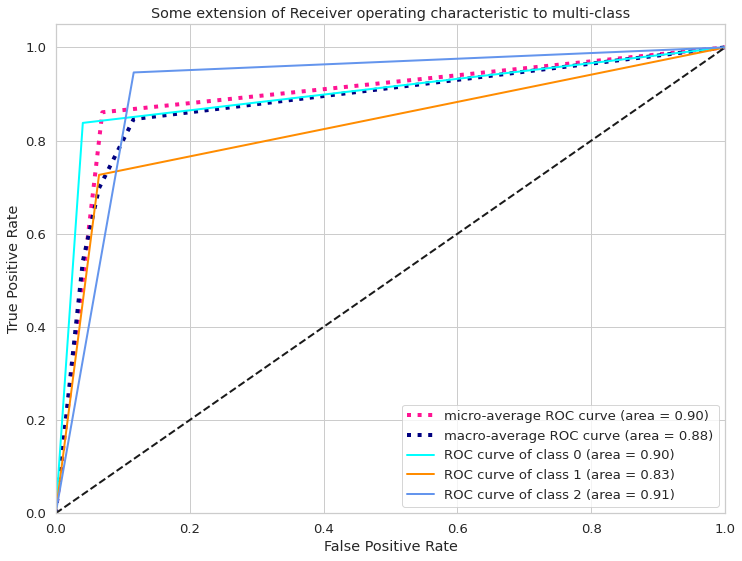

In [129]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()